In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from fit import *
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Simulate RL_nv with different $\sigma$, $v$

In [ ]:
def bayes_noise(obs, noise_n=0, noise_e=0, seed=0):
    rng = np.random.RandomState(seed=seed)
    expectation = 0
    for o in range(len(obs)):
        weight = 1/(o+3)
        dW = rng.uniform((1-noise_n)*weight, (1+noise_n)*weight)
        weight = dW
        weight = np.clip(weight, 0, 1)
        error = obs[o] - expectation
        expectation += weight * error
        dE = rng.uniform((1-noise_e)*expectation, (1+noise_e)*expectation)
        expectation = dE
        expectation = np.clip(expectation, -1, 1)
    weight_ideal = 1/(o+3)
    expectation_ideal = bayes_ideal(obs)
    return weight_ideal, weight, expectation_ideal, expectation

In [2]:
def run_RLn(sid, sigma):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    params = [mu, sigma]
    dfs = []
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    for trial in human['trial'].unique():
        for stage in human['stage'].unique():
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = get_expectations_carrabin("RL_n", params, sid, trial, stage)
            dfs.append(pd.DataFrame([["RL_n", sid, trial, stage, qid, response]], columns=columns))
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['sigma'] = sigma
    return dynamics_data

In [3]:
sid = 18
sigmas = [0.025, 0.05, 0.10]
dfs = []
for sigma in sigmas:
    dfs.append(run_RLn(sid, sigma))
RLn_data = pd.concat(dfs, ignore_index=True)

# Simulate NEF_RL with different $neurons$

In [2]:
def run_NEFRL(sid, n_neurons, n_error, n_learning):
    mu = pd.read_pickle(f"data/RL_n2_carrabin_{sid}_params.pkl")['mu'].unique()[0]
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    trials = human['trial'].unique() 
    columns = ['type', 'sid', 'trial', 'stage', 'qid', 'response']
    dfs = []
    for trial in trials:
        print(f"n_neurons {n_neurons}, n_error {n_error}, n_learning {n_learning}, sid {sid}, trial {trial}")
        env = Environment(dataset="carrabin", sid=sid, trial=trial, decay="stages", s=[mu,mu,mu,mu,mu])
        seed_net = sid + 1000*trial
        net = build_network_RL(env, n_neurons=n_neurons, n_error=n_error, n_learning=n_learning, seed_net=seed_net, z=0, a=5e-5)
        sim = nengo.Simulator(net, seed=trial, progress_bar=False)
        with sim:
            sim.run(env.Tall, progress_bar=False)
        for stage in env.stages:
            tidx = int((stage*env.T)/env.dt)-2
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response = sim.data[net.probe_value][tidx][0]
            df = pd.DataFrame([['NEF_RL', sid, trial, stage, qid, response]], columns=columns)
            dfs.append(df)
    dynamics_data = pd.concat(dfs, ignore_index=True)
    dynamics_data['n_neurons'] = n_neurons
    dynamics_data['n_error'] = n_error
    dynamics_data['n_learning'] = n_learning
    return dynamics_data

In [4]:
def process_plot(human, NEFRL_data):
    human['n_neurons'] = 'human'
    human['n_error'] = 'human'
    human['n_learning'] = 'human'
    combined = pd.concat([human, NEFRL_data], ignore_index=True)
    combined['alpha'] = None
    combined['excursion'] = None
    for i, row in combined.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        qid = row['qid']
        n_neurons = row['n_neurons']
        n_error = row['n_error']
        n_learning = row['n_learning']
        response = row['response']
        avg_response = combined.query("type==@mt & n_neurons==@n_neurons & n_error==@n_error & n_learning==@n_learning & qid==@qid")['response'].mean()
        combined.at[i, 'excursion'] = response - avg_response
        if stage>1:
            stage_old = stage - 1
            response_old = combined.query("type==@mt & trial==@trial & n_neurons==@n_neurons & n_error==@n_error & n_learning==@n_learning & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error)
            combined.at[i, 'alpha'] = alpha
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
    # plot learning rates on left
    sns.kdeplot(combined, x='alpha', hue='n_learning', ax=axes[0][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    # plot excursions on right
    sns.kdeplot(combined, x='excursion', hue='n_learning', ax=axes[0][1], palette=palette[:4], fill=True, common_norm=False)
    sns.kdeplot(combined, x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:4], fill=True, common_norm=False)
    axes[0][0].set(title='Distribution of Behavioral Learning Rates')
    axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
    axes[1][0].set(xlabel="Learning Rate")
    axes[1][1].set(ylabel=None, xlabel='Excursion')
    plt.tight_layout()
    plt.show()

In [5]:
sid = 18

# n_neurons = [50, 200]
n_error = [50, 200]
# n_learning = [50, 200]
n = 200
# e = 100
l = 200
dfs = []
# for n in n_neurons:
for e in n_error:
    # for l in n_learning:
    dfs.append(run_NEFRL(sid, n, e, l))
NEFRL_data = pd.concat(dfs, ignore_index=True)
human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")

n_neurons 200, n_error 50, n_learning 200, sid 18, trial 1
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 2
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 3
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 4
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 5
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 6
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 7
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 8
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 9
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 10
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 11
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 12
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 13
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 14
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 15
n_neurons 200, n_error 50, n_learning 200, sid 18, trial 16
n_neurons 200, n_error 50, n_learning 200, sid 18

KeyboardInterrupt: 

In [ ]:
process_plot(human, NEFRL_data)

## Load and Plot

In [18]:
noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb14all.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13five.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13four.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13three.pkl")
# noise_data = pd.read_pickle("data/NEF_RL_noise_RL_carrabin_feb13test.pkl")

In [19]:
def add_excursion_alpha(data):
    dfs = []
    human = pd.read_pickle(f"data/carrabin.pkl")
    sid_old = None
    for i, row in data.iterrows():
        mt = row['type']
        sid = row['sid']
        l = row['n_learning']
        e = row['n_error']
        trial = row['trial']
        stage = row['stage']
        qid = row['qid']
        response = row['response']
        avg_response = data.query("type==@mt & sid==@sid & n_learning==@l & n_error==@e & qid==@qid")['response'].mean()
        data.loc[i, 'excursion'] = response - avg_response
        if stage>1:
            stage_old = stage - 1
            response_old = data.query("type==@mt & sid==@sid & n_learning==@l & n_error==@e & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
            data.loc[i, 'alpha'] = alpha
        if sid!=sid_old: print(f"sid {sid}")
        sid_old = sid
    return data

In [ ]:
combined = add_excursion_alpha(noise_data)

sid 1
sid 2


In [12]:
combined.to_pickle("data/alpha_excursions_feb14all.pkl")

In [13]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex='col', sharey='col')
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='alpha', hue='n_learning', ax=axes[0][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='alpha', hue='n_error', ax=axes[1][0], clip=[0, 1], palette=palette[:5], fill=True, common_norm=False)
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='excursion', hue='n_learning', ax=axes[0][1], palette=palette[:5], fill=True, common_norm=False)
# sns.kdeplot(combined_add.query("type=='NEF_RL'"), x='excursion', hue='n_error', ax=axes[1][1], palette=palette[:5], fill=True, common_norm=False)
# axes[0][0].set(title='Distribution of Behavioral Learning Rates')
# axes[0][1].set(title='Distribution of Excursions', xlabel="Excursion", ylabel=None, xlim=[-0.5,0.5])
# axes[1][0].set(xlabel="Learning Rate")
# axes[1][1].set(ylabel=None, xlabel='Excursion')
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_11581/1080761528.py:2: FutureWarning: The provided callable <function std at 0x798768366ac0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  alpha_pivot = combined.pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc=np.std)
/tmp/ipykernel_11581/1080761528.py:3: FutureWarning: The provided callable <function std at 0x798768366ac0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  excursion_pivot = combined.pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc=np.std)


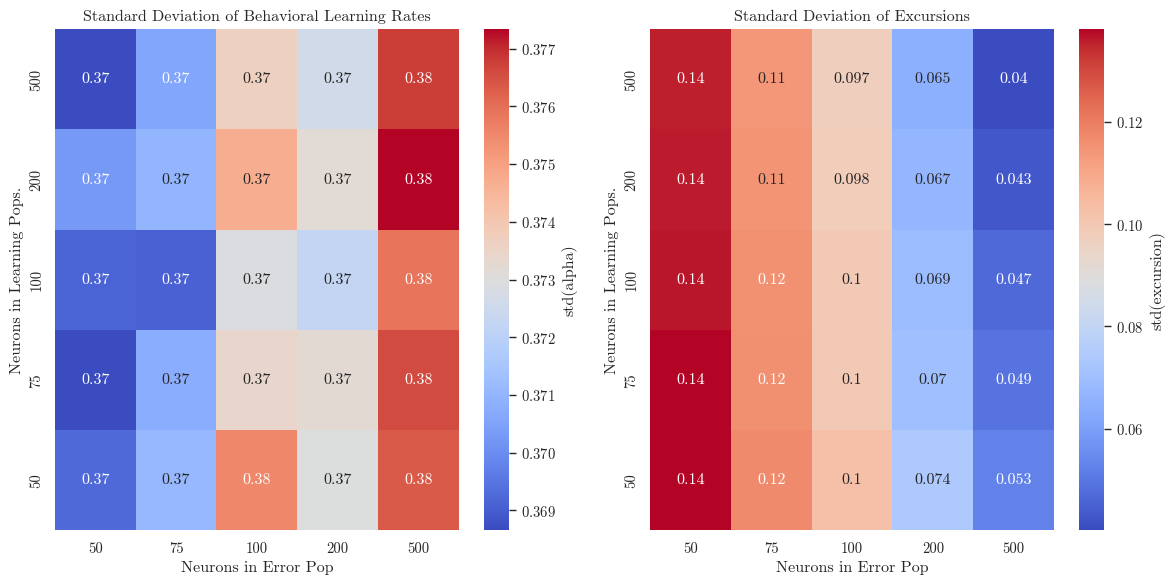

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
alpha_pivot = combined.pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc=np.std)
excursion_pivot = combined.pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc=np.std)
sns.heatmap(data=alpha_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(alpha)'}, ax=axes[0])
sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(excursion)'}, ax=axes[1])
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].set(ylabel="Neurons in Learning Pops.", xlabel="Neurons in Error Pop", title="Standard Deviation of Behavioral Learning Rates")
axes[1].set(ylabel="Neurons in Learning Pops.", xlabel="Neurons in Error Pop", title="Standard Deviation of Excursions")
plt.tight_layout()
fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)

In [ ]:
fig, axes = plt.subplots(nrows=len(combined['sid'].unique()), ncols=2, figsize=(12,6*len(combined['sid'].unique())))
for s, sid in enumerate(combined['sid'].unique()):
    alpha_pivot = combined.query("sid==@sid").pivot_table(index='n_learning', columns='n_error', values='alpha', aggfunc='std')
    excursion_pivot = combined.query("sid==@sid").pivot_table(index='n_learning', columns='n_error', values='excursion', aggfunc='std')
    sns.heatmap(data=alpha_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(alpha)'}, ax=axes[s][0])
    sns.heatmap(data=excursion_pivot, annot=True, cmap="coolwarm", cbar_kws={'label': 'std(excursion)'}, ax=axes[s][1])
    axes[s][0].invert_yaxis()
    axes[s][1].invert_yaxis()
    axes[s][0].set(ylabel="Neurons in Learning Pops.", xlabel="Neurons in Error Pop", title="Standard Deviation of Behavioral Learning Rates")
    axes[s][1].set(ylabel="Neurons in Learning Pops.", xlabel="Neurons in Error Pop", title="Standard Deviation of Excursions")
    plt.tight_layout()
    # fig.savefig("plots/noise_RL_vs_neurons.jpg", dpi=600)

### Compare to distribution of std(alpha) and std(excursion) across human SIDs

In [9]:
human = pd.read_pickle("data/carrabin.pkl")
human['n_learning'] = 'human'
human['n_error'] = 'human'
human_add = add_excursion_alpha(human)
dfs = []
columns = ['type', 'sid', 'std alpha', 'std excursion']
for sid in human_add['sid'].unique():
    std_alpha = human_add.query("sid==@sid")['alpha'].std()
    std_excursion = human_add.query("sid==@sid")['excursion'].std()
    dfs.append(pd.DataFrame([['human', sid, std_alpha, std_excursion]], columns=columns))
human_stds = pd.concat(dfs, ignore_index=True)

sid 1
sid 2
sid 3
sid 4


/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykern

sid 5


/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)


sid 6


/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykerne

sid 7
sid 8
sid 9


/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)
/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.abs(delta / prediction_error)


sid 10
sid 11
sid 12
sid 13


/tmp/ipykernel_17296/3659123973.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = np.abs(delta / prediction_error)


sid 14
sid 15
sid 16
sid 17
sid 18
sid 19
sid 20
sid 21


/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/psipeter/observational-learning-social-networks/venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


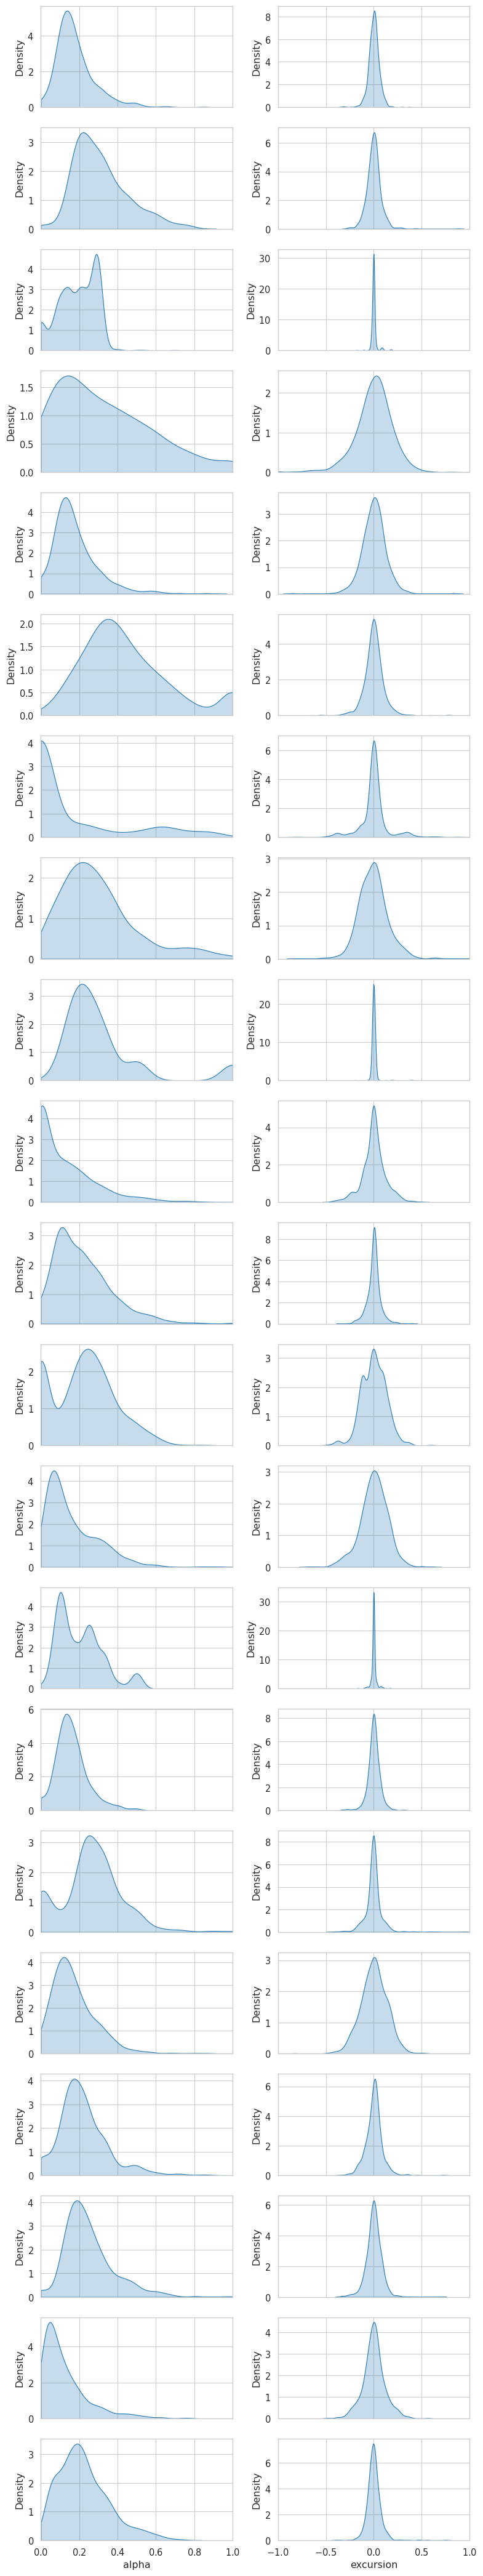

In [17]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=len(human['sid'].unique()), ncols=2, figsize=(8,2*len(human['sid'].unique())), sharex='col')
    for s, sid in enumerate(human['sid'].unique()):
        sns.kdeplot(human_add.query("sid==@sid"), x='alpha', clip=[0,1], ax=axes[s][0], color=palette[0], fill=True, common_norm=False)
        sns.kdeplot(human_add.query("sid==@sid"), x='excursion', clip=[-1,1], ax=axes[s][1], color=palette[0], fill=True, common_norm=False)
        axes[s][0].set(title=f"STD alpha = {human_add.query("sid==@sid")['alpha'].std}"
        axes[s][1].set(title=f"STD excursion = {human_add.query("sid==@sid")['excursion'].std}"
    axes[-1][0].set(xlim=[0,1])
    axes[-1][1].set(xlim=[-1,1])
    plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.kdeplot(human_stds, x='std alpha', ax=axes[0], clip=[0, 1], color=palette[0], fill=True, common_norm=False)
sns.kdeplot(human_stds, x='std excursion', ax=axes[1], color=palette[0], fill=True, common_norm=False)
axes[0].set(title='Distribution of STD(alpha)', xlabel="std alpha")
axes[1].set(title='Distribution of STD(excursion)', xlabel="std excursion", ylabel=None)
plt.tight_layout()
# plt.show()
fig.savefig("plots/std_alpha_excursion_human.jpg", dpi=600)